### Importamos las librerías necesarias

In [1]:
from dotenv import load_dotenv
import mlflow
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay
import matplotlib.pyplot as plt
import os
import nbimporter

# Modelo `LinearRegression`

De la libreta `first_transform`, importamos la función `series_to_supervised` para poder transformar nuestro dataset en uno que pueda ser procesado por una regresión lineal:

In [2]:
from first_transform import series_to_supervised

### Cargando variables de entorno

Antes de comenzar, cargamos las variables de entorno necesarias para configurar `mlflow`. Las varibles se encuentran almacenadas en el archivo `.env`, por lo que es necesario configurarlas de antemano.
Para cargarlas, primero es necesario utilizar la función `load_dotenv`, seguido de `getenv` del módulo `os`:

In [3]:
load_dotenv()

True

In [4]:
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

### Cargando y preprocessando datos

Comenzando cargando nuestros datos procesados, para después pasarlos por la función `series_to_supervised` y así poderlos alimentar a nuestro modelo:

In [5]:
data = pd.read_csv('../data/processed/processed_data_energy.csv')

In [6]:
data.head()

,hora,dia,mes,anio,tmax-cab,tmax-hmo,tmax-obr,tmax-lmo,tmax-cul,tmin-cab,...,martes_postfestivo,semana_santa,1_mayo,10_mayo,16_sep,2_nov.,pre-navidad_y_new_year,navidad_y_new_year,post-navidad_y_new_year,demanda_energia
0,0,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1394
1,1,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1297
2,2,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1255
3,3,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1222
4,4,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1168


In [7]:
supervised_data = series_to_supervised(data[data.columns[4:]], n_in=12, n_out=1)

In [8]:
supervised_data.head()

,tmax-cab(t-12),tmax-hmo(t-12),tmax-obr(t-12),tmax-lmo(t-12),tmax-cul(t-12),tmin-cab(t-12),tmin-hmo(t-12),tmin-obr(t-12),tmin-lmo(t-12),tmin-cul(t-12),...,martes_postfestivo(t),semana_santa(t),1_mayo(t),10_mayo(t),16_sep(t),2_nov.(t),pre-navidad_y_new_year(t),navidad_y_new_year(t),post-navidad_y_new_year(t),demanda_energia(t)
12,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1079
13,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1086
14,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1083
15,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1073
16,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1067


Una vez cargados y transformados los datos, podemos proceder a separarlos y con su preprocesamiento:

In [9]:
X = supervised_data.drop(columns=['demanda_energia(t)'])
y = pd.DataFrame(supervised_data['demanda_energia(t)'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Una vez separados los datos, podemos proceder a su preprocesamiento, el cual en este caso consiste en una simple normalización.

In [11]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(y_train)

### Entrenando modelo sencillo (con mlflow)

Una vez hecho lo anterior, generamos nuestro modelo de regresión lineal:

In [12]:
lr_model = LinearRegression()

Antes de comenzar a generar y entrenar nuestro modelo de aprendizaje automático, es necesario configurar el mlflow para indicarle donde se encuentra nuestro `remote`, recordemos que el URI se cargó anteriormente a partir del archivo `.env`.

Igualmente, activamos la función `autolog` para `sklearn` para que se haga un log de todas las métricas y entrenamientos que hagamos:

In [18]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(experiment_name="Linear_Regression_Model")
mlflow.sklearn.autolog()

2024/05/23 18:17:14 INFO mlflow.tracking.fluent: Experiment with name 'Linear_Regression_Model' does not exist. Creating a new experiment.


Una vez hecho lo anterior, generamos nuestro modelo de regresión lineal:

In [19]:
lr_model = LinearRegression()

Una vez generada la curva de aprendizaje, podemos proceder a ajustar nuestro modelo a los datos de entrenamiento:

In [20]:
lr_model.fit(X_scaled, y_scaled)

2024/05/23 18:17:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a24a49a067a34d34bc598394833a7e84', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/23 18:17:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jesusg/anaconda3/envs/energy_prediction/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


LinearRegression()

Antes de proceder a evaluar nuestro modelo con los datos de prueba, es necesario escalarlos de forma similar a los de entrenamiento:

In [21]:
X_test_scaled = scaler_x.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

In [22]:
y_pred = lr_model.predict(X_test_scaled)

In [23]:
lr_model.score(X_test_scaled, y_test_scaled)

0.9954397040721062

Antes de calcular las metricas de evaluación, y para una interpretación mas sencilla de las mismas, podemos hacer un escalamiento inverso en nuestras predicciones, para después proceder a calcular las métricas a partir de estos valores no escalados:

In [24]:
y_pred_unscaled = scaler_y.inverse_transform(y_pred)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

In [26]:
mse = mean_squared_error(y_test, y_pred_unscaled)
print(f"El error cuadrado medio tiene un valor de {mse:.2f}")

El error cuadrado medio tiene un valor de 2893.57


In [27]:
mape = mean_absolute_percentage_error(y_test, y_pred_unscaled)
print(f"El MAPE tiene un valor de {mape:.2f}")

El MAPE tiene un valor de 0.02


In [33]:
rmse = root_mean_squared_error(y_test, y_pred_unscaled)
print(f"La raíz del error cuadrático medio tiene un valor de {rmse:.2f}")

La raíz del error cuadrático medio tiene un valor de 53.79


Vemos que, mientras el error cuadrado medio tiende a ser algo elevado, nuestra métrica objetivo (MAPE) alcanza un valor de **menos del 2%**.

Despues, procedemos a actualizar manualmente nuestras metricas en mlflow, ya que la funcion autolog no registra las metricas cuando se altera o copia las predicciónes del modelo. (En este caso, las modificamos al utilzar los scalers)

In [28]:
mlflow.end_run()

In [34]:
with mlflow.start_run('a24a49a067a34d34bc598394833a7e84') as run: # Reemplazar con el valor del run a actualizar
    mlflow.log_metric("test_mean_absolute_percentage_error_unscaled", mape)
    mlflow.log_metric("test_mean_squared_error_unscaled", mse)
    mlflow.log_metric("test_root_mean_squared_error_unscaled", rmse)

Finalmente, podemos visualizar mejor las predicciones de nuestro modelo si comparamos los valores predichos contra los valores reales del dataset de prueba. Idealmente, deberiamos ver nuestro plot como una línea de pendiente 1:

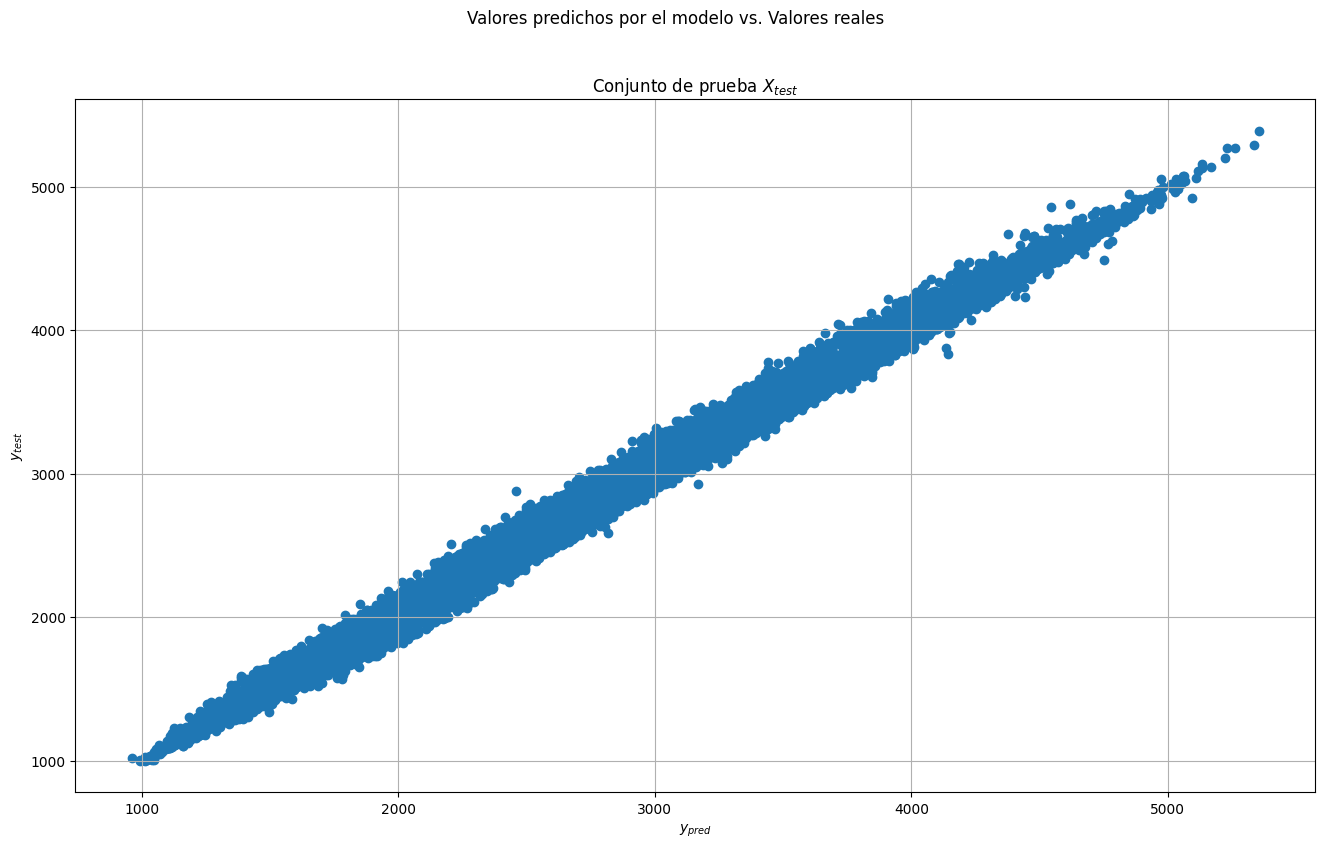

In [36]:
fig,ax = plt.subplots(figsize=(16,9))
fig.suptitle("Valores predichos por el modelo vs. Valores reales")
ax.set_title(r"Conjunto de prueba $X_{test}$")
ax.grid()
ax.scatter(y_pred_unscaled, y_test)
ax.set_ylabel(r'$y_{test}$')
ax.set_xlabel(r'$y_{pred}$')
plt.show()

Como podemos apreciar con la gráfica anterior y con las métricas, el modelo de regresión lineal presenta un ajuste muy bueno para nuestro problema, después de haber procesado los datos para transormarlos al estilo de un modelo de aprendizaje supervisado. 